### Imports

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),      
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

dataset = datasets.ImageFolder(root="../Pre-processing/dataset/face_dataset/", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)


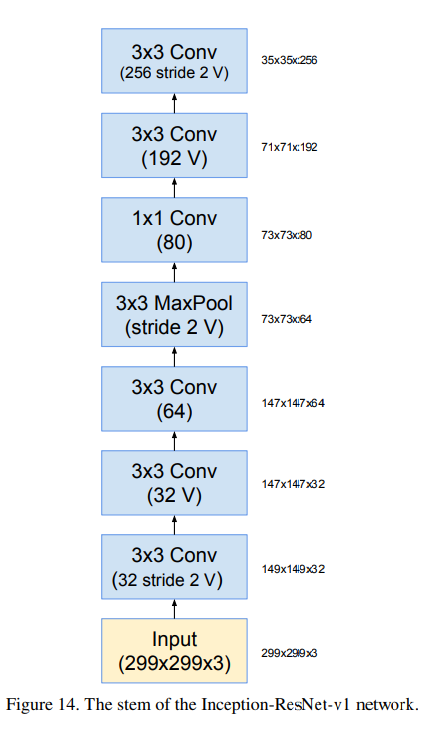

In [46]:
###
# Def Inception_Stem The stem from Incetion-ResNet-v1
# input_shape - The shape of our input image (height, width, channels)
# Returns - The tensor after passing through the stem block.
###
class Inception_stem(nn.Module):
    def __init__(self, input_channels=3):
        super(Inception_stem, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        self.conv4 = nn.Conv2d(64, 80, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(80, 192, kernel_size=3, stride=1, padding=0)
        self.conv6 = nn.Conv2d(192, 256, kernel_size=3, stride=2, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.relu(self.conv1(x))  # Output: 149x149x32
        x = self.relu(self.conv2(x))  # Output: 147x147x32
        x = self.relu(self.conv3(x))  # Output: 147x147x64
        x = self.maxpool(x)           # Output: 73x73x64
        x = self.relu(self.conv4(x))  # Output: 73x73x80
        x = self.relu(self.conv5(x))  # Output: 71x71x192
        x = self.relu(self.conv6(x))  # Output: 35x35x256
        return x

input_tensor = torch.randn(1, 3, 299, 299)
model = Inception_stem(input_channels=3)
output = model(input_tensor)
print("outputShape: ", output.shape)


outputShape:  torch.Size([1, 256, 35, 35])


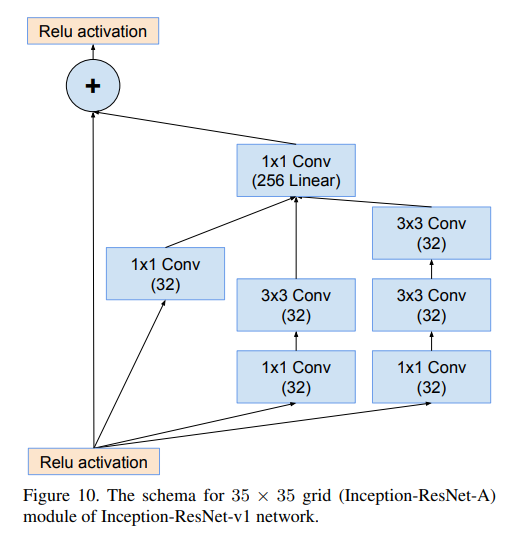

In [47]:
### 
# InceptionResNetABlock: Defines one Inception-ResNet-A block of size 35x35
# filters - The amount of filters for the convolutions
# Returns - The tensor after the A block
###
class InceptionResNet_A_Block(nn.Module):
    def __init__(self, filters=32):
        super(InceptionResNet_A_Block, self).__init__()

        # Branch 1
        self.branch1 = nn.Conv2d(256, filters, kernel_size=1, stride=1, padding=0)

        # Branch 2
        self.branch2_1 = nn.Conv2d(256, filters, kernel_size=1, stride=1, padding=0)
        self.branch2_2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)

        # Branch 3
        self.branch3_1 = nn.Conv2d(256, filters, kernel_size=1, stride=1, padding=0)
        self.branch3_2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        self.branch3_3 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)

        self.reduced_conv = nn.Conv2d(filters*3, 256, kernel_size=1, stride=1, padding=0) # (*3 because 3 dimensions)
        self.relu = nn.ReLU()

    def forward(self, x):

        # Branch 1
        branch_1 = self.relu(self.branch1(x))

        # Branch 2
        branch_2 = self.relu(self.branch2_1(x))
        branch_2 = self.relu(self.branch2_2(branch_2))

        # Branch 3
        branch_3 = self.relu(self.branch3_1(x))
        branch_3 = self.relu(self.branch3_2(branch_3))
        branch_3 = self.relu(self.branch3_3(branch_3))

        # Concatenate all branches along the channel dimension
        mixed = torch.cat([branch_1, branch_2, branch_3], dim=1)

        reduced = self.reduced_conv(mixed)
        output = torch.add(x, reduced)
        output = self.relu(output)

        return output
    
input_tensor = torch.randn(1, 256, 35, 35)
model = InceptionResNet_A_Block()
output = model(input_tensor)
print("outputShape: ", output.shape)


outputShape:  torch.Size([1, 256, 35, 35])


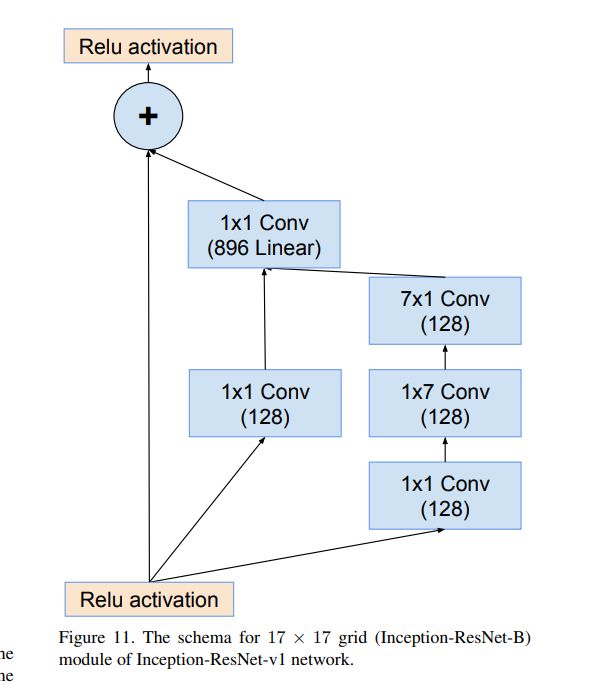

In [48]:
### 
# InceptionResNet_B_Block: Defines one Inception-ResNet-B block of size 17x17
# filters - The amount of filters for the convolutions
# in_channels - The amount of input channels
# Returns - The tensor after the B block
### 
class InceptionResNet_B_Block(nn.Module):
    def __init__(self, in_channels, filters=32):
        super(InceptionResNet_B_Block, self).__init__()

        # Branch 1
        self.branch1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)

        # Branch 2
        self.branch2_1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)
        self.branch2_2 = nn.Conv2d(filters, filters, kernel_size=(1,7), stride=1, padding=(0,3))
        self.branch2_3 = nn.Conv2d(filters, filters, kernel_size=(7,1), stride=1, padding=(3,0))

        self.reduced_conv = nn.Conv2d(filters*2, 256, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Branch 1
        branch_1 = self.relu(self.branch1(x))

        # Branch 2
        branch_2 = self.relu(self.branch2_1(x))
        branch_2 = self.relu(self.branch2_2(branch_2))

        # Concatenate
        mixed = torch.cat([branch_1, branch_2], dim=1)

        reduced = self.reduced_conv(mixed)
        output = torch.add(x, reduced)
        output = self.relu(output)

        return output

input_tensor = torch.randn(1, 256, 17, 17)
model = InceptionResNet_B_Block(in_channels=256)
output = model(input_tensor)
print("outputShape: ", output.shape)

outputShape:  torch.Size([1, 256, 17, 17])


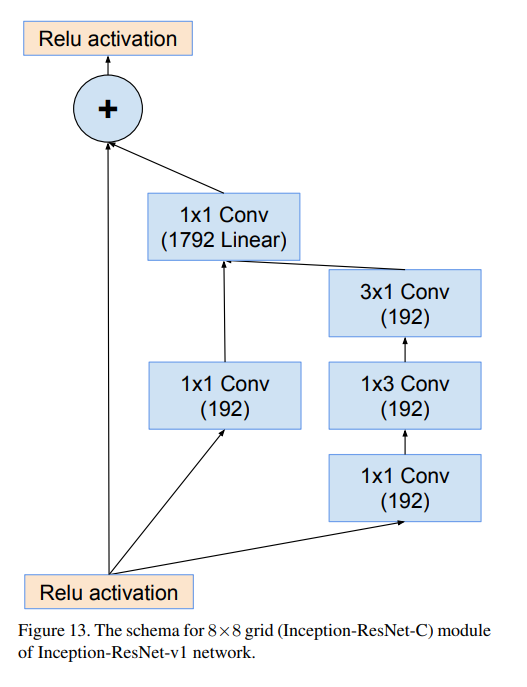

In [49]:
### 
# InceptionResNet_C_Block: Defines one Inception-ResNet-C block of size 8x8
# in_channels - The amount of input channels
# filters - The amount of filters for the convolutions
# Returns - The tensor after the C block
###
class InceptionResNet_C_Block(nn.Module):
    def __init__(self, in_channels, filters=32):
        super(InceptionResNet_C_Block, self).__init__()

        # Branch 1
        self.branch_1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)

        # Branch 2
        self.branch_2_1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)
        self.branch_2_2 = nn.Conv2d(filters, filters, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch_2_3 = nn.Conv2d(filters, filters, kernel_size=(3, 1), stride=1, padding=(1, 0))

        # 1x1 Convolution to reduce dimensions (256 Linear)
        self.reduced = nn.Conv2d(filters*2, 256, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Branch 1
        branch_1 = self.branch_1(x)

        # Branch 2
        branch_2 = self.branch_2_1(x)
        branch_2 = self.branch_2_2(branch_2)
        branch_2 = self.branch_2_3(branch_2)

        # Concatenate
        mixed = torch.cat([branch_1, branch_2], dim=1)
        reduced = self.reduced(mixed)
        output = x + reduced
        output = F.relu(output)

        return output
    
input_tensor = torch.randn(1, 256, 8, 8)
model = InceptionResNet_C_Block(in_channels=256)
output = model(input_tensor)
print("outputShape: ", output.shape)

outputShape:  torch.Size([1, 256, 8, 8])


In [50]:
### 
# FullyConnectedLayer: Adds a fully connected layer with dropout
# in_channels - The amount of input channels
# feature_dim: d from article
# dropout_rate: The dropout rate
# returns - the tensor after the FCL
###
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_channels, feature_dim, dropout_rate=0.8):
        super(FullyConnectedLayer, self).__init__()

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_channels, feature_dim)

    def forward(self, x):
        x = self.global_avg_pool(x)

        # Flatten [batch_size, channels, 1, 1] to [batch_size, channels]
        x = torch.flatten(x, 1) 
        x = self.dropout(x)
        x = self.fc(x)

        return x

batch_size = 1
channels = 256  
height = 8     
width = 8  
feature_dim = 128

input_tensor = torch.randn(batch_size, channels, height, width)
model = FullyConnectedLayer(in_channels=channels, feature_dim=feature_dim)
output = model(input_tensor)
print(f"Output shape: {output.shape}")



Output shape: torch.Size([1, 128])


In [51]:
###
# feature_net: Implements the feature net from BioMetricNet: https://arxiv.org/pdf/2008.06021
# input_shape: The shape of the images as inputs, in the paper they use 299, 299, 3
# feature_dim: The size of the output feature vector (d), see paper
# dropout_rate: The dropout rate (reduces overfitting by randomly dropping neurons during training, ensuring the network generalizes well)
###
class FeatureNet(nn.Module):
    def __init__(self, input_shape, feature_dim=128, dropout_rate=0.8):
        super(FeatureNet, self).__init__()

        self.inception_stem = Inception_stem(input_shape)
        self.inception_resnet_a = InceptionResNet_A_Block(filters=32)  
        self.inception_resnet_b = InceptionResNet_B_Block(filters=32)  
        self.inception_resnet_c = InceptionResNet_C_Block(filters=32)  
        self.fc_layer = FullyConnectedLayer(in_channels=256, feature_dim=feature_dim, dropout_rate=dropout_rate)

    def forward(self, x):

        x = self.inception_stem(x)
        
        for _ in range(5):
            x = self.inception_resnet_a(x)
        
        for _ in range(10):
            x = self.inception_resnet_b(x)

        for _ in range(5):
            x = self.inception_resnet_c(x)
        
        x = self.fc_layer(x)
        
        return x

input_tensor = torch.randn(1, 3, 299, 299)
model = FeatureNet(input_shape=(3, 299, 299), feature_dim=64)
output = model(input_tensor)
print(output.shape)


TypeError: unsupported operand type(s) for %: 'tuple' and 'int'